<h><font size = "4"><center><b>Astrofísica Computacional</b></center></font></h>
<h><center>Ejercicios 06. Volúmenes Finitos. Advección multi-dimensional</center></h>

**A. Solución de la ecuación de advección lineal 1D.**

La ecuación de advección lineal en una dimensión es
\begin{equation}
    \frac{\partial \psi}{\partial t} + v \frac{\partial \psi}{\partial x} = 0\,,
\end{equation}
donde la velocidad de advección , $v$, es una constante.

1. Implemente un código que resuelva numéricamente esta ecuación utilizando el método de volúmenes finitos. Considere como condición inicial un perfil gaussiano,
\begin{equation}
    \Psi_0 = \psi(x, t=0) = e^{-\frac{(x - x_0)^2}{2\sigma^2}}\,,
\end{equation}
con $x_0 = 30$, $\sigma = \sqrt{15}$ y un perfil sinusoidal
\begin{equation}
    \Psi_0 = \psi(x, t=0) = \sin{\left(\frac{4\pi x}{L}\right)}
\end{equation}
con $L=100$. En los dos casos, considere una velocidad de advección constante positiva $v=0.2$ y resuelva en el dominio espacial $x \in \left[0,100\right]$ para un intervalo temporal con $t \in [0,1000]$. Implemente condiciones de frontera periódicas en los dos casos.

**B. Advección Multidimensional**

La ecuación de avección lineal 2-dimensional es
\begin{equation}
    \partial_t\pi + v^x \partial_x\psi + v^y \partial_y\psi = 0\,,
\end{equation}
donde $v^x$ y $v^y$ son las componentes de la velocidad en las direcciones $x$ y $y$, respectivamente.

1. Resuelva numéricamente la ecuación de advección 2-dimensional mediante el método de volúmenes finitos considerando un perfil inicial Gaussiano,
\begin{equation}
    \Psi_0 = \psi(t=0, x, y) = e^{-\frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma^2}}
\end{equation}
donde $x_0 = 20$, $y_0 = 30$, $\sigma = \sqrt{20}$ y considerando $v^x = 0.8$, $v^y = 1.0$ en el dominio espacial $x \in [0, 100]$ y $y \in [0,100]$. Además implemente la posibilidad de condiciones de frontera de gradiente nulo (outflow) y periódicas.

---
## **Desarrollo**

**A.1.** Primero que todo cargamos las librerías que se van a utilizar

In [1]:
using Plots
using Printf

Posteriormente escribimos la función que dará el perfil inicial gaussiano del comportamiento que estamos describiendo, junto con los intervalos y pasos de tiempo y posición en los que vamos a analizar el comportamiento de nuestro método numérico.

In [2]:
function Gaussian_profile(x)
    x0 = 30
    sigma = sqrt(15)
    prof = exp(-(x-x0)^2/(2*sigma^2))
    return prof
end

#spacial grid
x_i = 0
x_f = 100
Nx = 1000
x = LinRange(x_i, x_f, Nx)

#Criterio CFL
v = 0.2 #velocity
CFL = 0.1
dx = x[2] - x[1]
dt = CFL*dx/abs(v)

#time grid
t_i = 0
t_f = 1000
Nt = round(Int64, (t_f - t_i)/dt)
t = LinRange(t_i, t_f, Nt)

19980-element LinRange{Float64}:
 0.0,0.0500526,0.100105,0.150158,0.20021,…,999.8,999.85,999.9,999.95,1000.0

Así, establecido nuestro dominio espacial y temporal junto con el grid respectivo de cada uno de ellos, implementamos la función de integración de la ecuación diferencial de advección por el método de volúmenes finitos.

dt = 0.0500500501 
dx = 0.1001001001

┌ Info: Saved animation to 
│   fn = /home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_gaussian_outflow.gif
└ @ Plots /home/juanessao2000/.julia/packages/Plots/AJMX6/src/animation.jl:114


dt = 0.0500500501 
dx = 0.1001001001

┌ Info: Saved animation to 
│   fn = /home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_gaussian_periodical.gif
└ @ Plots /home/juanessao2000/.julia/packages/Plots/AJMX6/src/animation.jl:114


Plots.AnimatedGif("/home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_gaussian_periodical.gif")
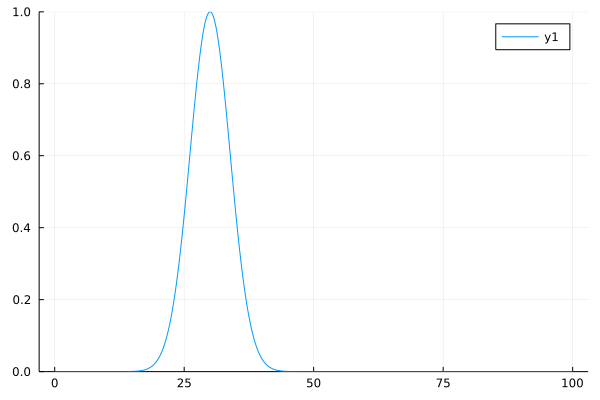

In [3]:
#flux function
flux(psi::Float64,v::Float64) = v*psi

function Finite_Volume_try1(Psi0, F, t, x, v, dt, dx, boundary = "outflow")
    nx = length(x)
    nt = length(t)
    psi = zeros(nt, nx)
    psi[1,1:length(x)] = Psi0.(x)
    psi_upwind = psi[1,1]
    psi_downwind = psi[1,nx]
    nu = (v*dt)/dx
    psi_half = zeros(nx-1)
    for n in 1:length(t)-1
        #Riemman's problem
        if v>0
            for j in 2:nx-1
                psi_half[j] = psi[n,j] + (dx)*0.5*(1-nu)*(psi[n,j+1] - psi[n,j-1])/(2*dx)
            end
            #lateral derivative
            psi_half[1] = psi[n,1] + (dx)*0.5*(1-nu)*(psi[n,2] - psi[n,1])/dx
        else
            for j in nx-2:-1:1
                psi_half[j] = psi[n,j+1] - (dx)*0.5*(1+nu)*(psi[n,j+2] - psi[n,j])/(2*dx)
            end
            #lateral derivative
            psi_half[nx-1] = psi[n,nx] - (dx)*0.5*(1+nu)*(psi[n,nx] - psi[n,nx-1])/dx
        end
            
        #Next step
        for j in 2:nx-1
            #First half - it depends on the boundary conditions
            psi[n+1,j] = psi[n,j] - (dt/dx)*(F(psi_half[j],v) - F(psi_half[j-1],v))
        end
            
        #Boundary conditions
        if boundary=="outflow" # Outflow boundary conditions
            psi[n+1,1] = psi[n+1,2]
            psi[n+1,nx] = psi[n+1,nx-1]
        else # Periodic boudnary conditions
            if v>0
                psi[n+1,1] = psi[n+1,nx-1]
                psi[n+1,nx] = psi[n+1,nx-1]
            else
                psi[n+1,1] = psi[n+1,2]
                psi[n+1,nx] = psi[n+1,1]
            end
        end
    end
    return psi
end
#type of boundary conditions
boundary = "outflow"
psi_fv_outflow = Finite_Volume_try1(Gaussian_profile, flux, t, x, v, dt, dx, boundary)

@printf("dt = %0.10f \n", dt)
@printf("dx = %0.10f", dx)
anim = @animate for i in 1:50:Nt 
    plot(x, psi_fv_outflow[i,:], ylim = (0,1))
end
gif(anim, "Finite_Volume_gaussian_"*boundary*".gif", fps = 15)

#type of boundary conditions
boundary = "periodical"
psi_fv_period = Finite_Volume_try1(Gaussian_profile, flux, t, x, v, dt, dx, boundary)

@printf("dt = %0.10f \n", dt)
@printf("dx = %0.10f", dx)
anim = @animate for i in 1:50:Nt 
    plot(x, psi_fv_period[i,:], ylim = (0,1))
end
gif(anim, "Finite_Volume_gaussian_"*boundary*".gif", fps = 15)

Este método tiene implementadas ambas condiciones, tanto upwind como downwind, luego funciona para valores positivos y negativos de velocidad. Cabe mencionar que para calcular las derivadas en los extremos para el paso intermedio no se usó la derivada centrada sino la derivada por derecha para upwind y la derivada por derecha para downwind, de tal manera que estas se pudieran hacer con valores conocidos de la función en el paso anterior.

Ahora utilizamos la misma función de integración pero ahora estableciendo un perfil sinusoidal

dt = 0.0500500501 
dx = 0.1001001001

┌ Info: Saved animation to 
│   fn = /home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_sine_outflow.gif
└ @ Plots /home/juanessao2000/.julia/packages/Plots/AJMX6/src/animation.jl:114


dt = 0.0500500501 
dx = 0.1001001001

┌ Info: Saved animation to 
│   fn = /home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_sine_periodical.gif
└ @ Plots /home/juanessao2000/.julia/packages/Plots/AJMX6/src/animation.jl:114


Plots.AnimatedGif("/home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_sine_periodical.gif")
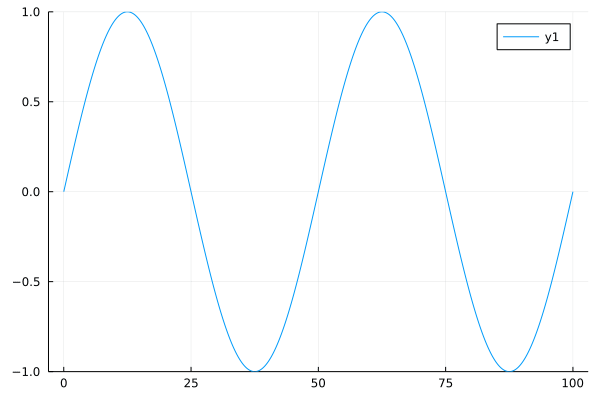

In [4]:
function sin_profile(x)
    L = 100
    prof = sin(4*pi*x/L)
    return prof
end

boundary = "outflow"
psi_fv2_outflow = Finite_Volume_try1(sin_profile, flux, t, x, v, dt, dx)
@printf("dt = %0.10f \n", dt)
@printf("dx = %0.10f", dx)
anim = @animate for i in 1:50:Nt 
    plot(x, psi_fv2_outflow[i,:], ylim = (-1,1))
end
gif(anim, "Finite_Volume_sine_outflow.gif", fps = 15)

boundary = "periodical"
psi_fv2_period = Finite_Volume_try1(sin_profile, flux, t, x, v, dt, dx, boundary)
@printf("dt = %0.10f \n", dt)
@printf("dx = %0.10f", dx)
anim = @animate for i in 1:50:Nt 
    plot(x, psi_fv2_period[i,:], ylim = (-1,1))
end
gif(anim, "Finite_Volume_sine_"*boundary*".gif", fps = 15)

**B.1**

Establecemos la función de perfil inicial gaussiano en dos dimensiones y el dominio de integración.

In [18]:
function gaussian_profile_2D(x, y)
    x0 = 20
    y0 = 30
    sigma = sqrt(20)
    prof = exp(-((x-x0)^2 + (y-y0)^2)/(2*sigma^2))
    return prof
end

xi = 0
xf = 100
Nx = 100
x = LinRange(xi, xf, Nx)
dx = x[2] - x[1]

yi = 0
yf = 100
Ny = 100
y = LinRange(yi, yf, Ny)
dy = y[2] - y[1]

#Advection velocity
vx = 0.8
vy = 1.0
v_2D = sqrt(vx^2+vy^2)
dr = sqrt(dx^2 + dy^2)

#Criterio CFL
CFL = 0.1
dt = CFL*dr/abs(v_2D)

#time grid
t_i = 0
t_f = 1000
Nt = round(Int64, (t_f - t_i)/dt)
t = LinRange(t_i, t_f, Nt)

8965-element LinRange{Float64}:
 0.0,0.111557,0.223115,0.334672,0.446229,…,999.665,999.777,999.888,1000.0

Empleando el método de división dimensional para la evolución mediante volúmenes finitos usando el algoritmo:

- Problema de Riemman para la coordenada $x$ - tener en cuenta solo si vy<0 o vy>0 - hay que hacerlo para cada punto del dominio total
\begin{equation}
\psi_{i+\frac{1}{2},j}^{n+\frac{1}{2}} = \mathcal{R}{\left(\psi_{i+\frac{1}{2},j, L}^{n+\frac{1}{2}}, \psi_{i+\frac{1}{2},j, R}^{n+\frac{1}{2}}\right)}
\end{equation}

- Calcular el $\bar{\psi}_{i,j}$
\begin{equation}
\bar{\psi}_{i,j} = \psi_{i,j}^n 
  - \Delta t \frac{ u \psi_{i+\frac{1}{2},j}^{n+\frac{1}{2}} - u \psi_{i-\frac{1}{2},j}^{n+\frac{1}{2}} }{\Delta x}\\
\end{equation}

- Calcular el problema de Riemann para la coordenada $y$ con los valores de $\bar{\psi}_{i,j}$
\begin{equation}
\bar{\psi}_{i,j+\frac{1}{2}}^{n+\frac{1}{2}} = \mathcal{R}{\left(\bar{\psi}_{i,j+\frac{1}{2}, L}^{n+\frac{1}{2}}, \bar{\psi}_{i,j+\frac{1}{2}, R}^{n+\frac{1}{2}}\right)}
\end{equation}

- Calcular el siguiente paso de tiempo 
\begin{equation}
\psi_{i,j}^{n+1} = \bar{\psi}_{i,j}
  - \Delta t \frac{ v \bar{\psi}_{i,j+\frac{1}{2}}^{n+\frac{1}{2}} - v \bar{\psi}_{i,j-\frac{1}{2}}^{n+\frac{1}{2}} }{\Delta y}.
\end{equation}

definimos entonces la función de integración mediante volúmenes finitos FV2D tal que se simula numéricamente la advección 2D de un perfil gaussiano con condiciones de frontera outflow por un lado y luego se simula con condiciones de frontera periódicas.

In [21]:
#flux function
flux(psi::Float64,v::Float64) = v*psi

function FV2D(Psi0, F, t, x, y, vx, vy, dt, dx, boundary = "outflow")
    nx = length(x)
    ny = length(y)
    nt = length(t)
    psi = zeros(nt, nx, ny)
    for i in 1:nx
        psi[1,i,:] = Psi0.(x[i],y)
    end
    nux = (vx*dt)/dx
    nuy = (vy*dt)/dx
    psi_half = zeros(nx-1,ny)
    psi_bar = zeros(nx,ny)
    psi_half_bar = zeros(nx,ny-1)
    for n in 1:nt-1
        #Riemann's problem x coordinate
        if vx>0
            for j in 2:nx-1
                psi_half[j,:] .= psi[n,j,:] .+ (dx)*0.5*(1-nux)*(psi[n,j+1,:] .- psi[n,j-1,:])/(2*dx)
            end
            #lateral derivative
            psi_half[1,:] .= psi[n,1,:] .+ (dx)*0.5*(1-nux)*(psi[n,2,:] .- psi[n,1,:])/dx
        else
            for j in nx-2:-1:1
                psi_half[j,:] .= psi[n,j+1,:] .- (dx)*0.5*(1+nux)*(psi[n,j+2,:] .- psi[n,j,:])/(2*dx)
            end
            #lateral derivative
            psi_half[nx-1,:] .= psi[n,nx,:] .- (dx)*0.5*(1+nux)*(psi[n,nx,:] .- psi[n,nx-1,:])/dx
        end
        #Next step in x coordinate
        for j in 2:nx-1
            #First half - it depends on the boundary conditions
            psi_bar[j,:] .= psi[n,j,:] .- (dt/dx)*(F.(psi_half[j,:],vx) .- F.(psi_half[j-1,:],vx))
        end
#         #Boundary conditions
        if boundary=="outflow" # Outflow boundary conditions
#             psi_bar[1,:] .= psi_bar[2,:]
#             psi_bar[nx,:] .= psi_bar[nx-1,:]
#             psi_bar[:,1] .= psi_bar[:,2]
#             psi_bar[:,ny] .= psi_bar[:,ny-1]
        else # Periodic boudnary conditions
            if vx>0
                psi_bar[1,:] .= psi_bar[nx-1,:]
                psi_bar[nx,:] .= psi_bar[nx-1,:]
            else
                psi_bar[1,:] .= psi_bar[2,:]
                psi_bar[nx,:] .= psi_bar[1,:]
            end
        end
        
        #Riemman's problem y coordinate
        if vy>0
            for k in 2:ny-1
                psi_half_bar[:,k] = psi_bar[:,k] + (dy)*0.5*(1-nuy)*(psi_bar[:,k+1] - psi_bar[:,k-1])/(2*dy)
            end
            #lateral derivative
            psi_half_bar[:,1] .= psi_bar[:,1] .+ (dy)*0.5*(1-nuy)*(psi_bar[:,2] .- psi_bar[:,1])/dy
        else
            for j in nx-2:-1:1
                psi_half_bar[:,k] = psi_bar[:,k+1] - (dy)*0.5*(1+nuy)*(psi_bar[:,k+2] - psi_bar[:,k])/(2*dy)
            end
            #lateral derivative
            psi_half_bar[:,ny-1] = psi_bar[:,ny] - (dy)*0.5*(1+nuy)*(psi_bar[:,ny] - psi_bar[:,ny-1])/dy
        end
            
        #Next general step
        for k in 2:ny-1
            #First half - it depends on the boundary conditions
            psi[n+1,:,k] .= psi_bar[:,k] - (dt/dy)*(F.(psi_half_bar[:,k],vy) .- F.(psi_half_bar[:,k-1],vy))
        end
            
        #Boundary conditions
        if boundary=="outflow" # Outflow boundary conditions
            psi[n+1,1,2:nx-1] .= psi[n+1,2,2:nx-1]
            psi[n+1,nx,2:nx-1] .= psi[n+1,nx-1,2:nx-1]
            psi[n+1,:,1] .= psi[n+1,:,2]
            psi[n+1,:,ny] .= psi[n+1,:,ny-1]
        else # Periodic boudnary conditions
            if vy>0
                psi[n+1,:,1] .= psi[n+1,:,ny-1]
                psi[n+1,:,ny] .= psi[n+1,:,ny-1]
            else
                psi[n+1,:,1] .= psi[n+1,:,2]
                psi[n+1,:,ny] .= psi[n+1,:,1]
            end
        end
        
    end
    return psi
end
psi_fv2D_outflow = FV2D(gaussian_profile_2D, flux, t, x, y, vx, vy, dt, dx, "outflow")
psi_fv2D_periodical = FV2D(gaussian_profile_2D, flux, t, x, y, vx, vy, dt, dx, "periodical")
dt

0.11154699603519853

Una vez guardados todos los perfiles para los distintos pasos de tiempo en la simulación se procede a graficar la evolución mediante un heatmap.

(8965, 100, 100)dt = 0.1115469960 
dx = 1.0101010101(8965, 100, 100)dt = 0.1115469960 
dx = 1.0101010101

┌ Info: Saved animation to 
│   fn = /home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_2D_outflow.gif
└ @ Plots /home/juanessao2000/.julia/packages/Plots/AJMX6/src/animation.jl:114
┌ Info: Saved animation to 
│   fn = /home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_2D_periodical.gif
└ @ Plots /home/juanessao2000/.julia/packages/Plots/AJMX6/src/animation.jl:114


Plots.AnimatedGif("/home/juanessao2000/Documents/1-PRINCIPAL-2022-1/1-UNIVERSIDAD/1- FÍSICA/3-NOVENO_SEMESTRE/COMPUTATIONAL_ASTROPHYSICS/ejercicios06-agudeloo_del_valle/Finite_Volume_2D_periodical.gif")
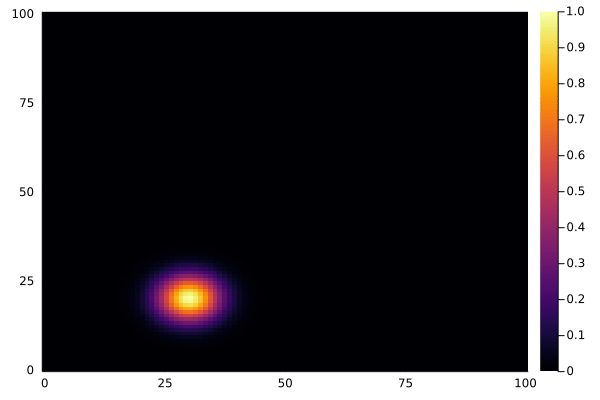

In [26]:
print(size(psi_fv2D_outflow))
@printf("dt = %0.10f \n", dt)
@printf("dx = %0.10f", dx)
anim = @animate for i in 1:50:2000 
    heatmap(x,y,psi_fv2D_outflow[i,:,:],clim=(0,1))
end
gif(anim, "Finite_Volume_2D_outflow.gif", fps = 15)
# heatmap(x, y, psi_fv2D[100,:,:])
print(size(psi_fv2D_periodical))
@printf("dt = %0.10f \n", dt)
@printf("dx = %0.10f", dx)
anim = @animate for i in 1:50:2000 
    heatmap(x,y,psi_fv2D_periodical[i,:,:],clim=(0,1))
end
gif(anim, "Finite_Volume_2D_periodical.gif", fps = 15)
# heatmap(x, y, psi_fv2D[100,:,:])